## ROI detection on CRX for COVID 19.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
from fastai.vision.all import *

from fastai.vision import *
# from fastai.metrics import accuracy
# from fastai.basic_data import *
# from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss
import cv2
from skimage.util import montage

## Getting and converting the data

In [50]:
path = '/home/robert/data/covid/ROI_detection/roi_detection_subset/'

In [51]:
batch_size = 16
img_size = 224


In [52]:
fname = '74282424579212606180428558707486659576_lmq73i.png'

In [53]:
def img2txt_name(f):
    f = os.path.basename(f)
    return path+f'{str(f)[:-4]}.txt'

/home/robert/data/covid/ROI_detection/roi_detection_subset/74282424579212606180428558707486659576_lmq73i.txt


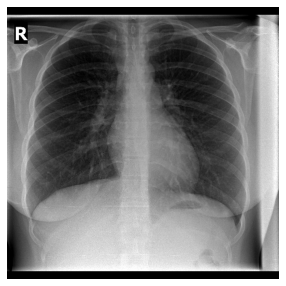

In [70]:
# img = open_image(path+'/'+fname)
img = PILImage.create(path+'/'+fname)
#img.resize(img_size)
img.show()
print(img2txt_name(fname))

In [55]:
ctr = np.genfromtxt(img2txt_name(Path(fname))); ctr

array([0.      , 0.468511, 0.427481, 0.818702, 0.725191])

In [90]:
def get_bbox(f):
    img = PILImage.create(path+fname)
    ctr = np.genfromtxt(img2txt_name(Path(f)))
    # YOLO format x, y, width and height. x, y is fucking center of the rectangle.
    cx = int(ctr[1]*img.size[0])
    cy = int(ctr[2]*img.size[1])
    
    w = int(ctr[3]*img.size[0])
    h = int(ctr[4]*img.size[1])
    
    # careful! fastaiv2 change x coordinate first!
    #miny minx maxy maxX
    bbox= np.zeros(4)
    bbox[0] = float(cx-w/2.0)#/img.size[0]#*img_size
    bbox[1] = float(cy-h/2.0)#/img.size[1]#*img_size
    bbox[2] = float(cx+w/2.0)#/img.size[0]#*img_size
    bbox[3] = float(cy+h/2.0)#/img.size[1]#*img_size
    
#    print(tensor(bbox))
    classes = int(0);
    aux = [[bbox],[classes]]
#    aux = [tensor(bbox),[classes]]
    return aux


In [72]:
print(img.size)

(524, 524)


In [20]:
LabeledBBox??


[[array([ 31.,  34., 459., 414.])], [0]]
(#2) [TensorBBox([[ 31.,  34., 459., 414.]]),[0]]


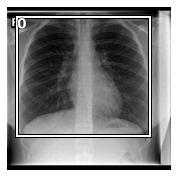

In [91]:
bbox = get_bbox(fname)
print(bbox)
# v1 bbox = ImageBBox.create(*img.size, bbox[0], labels = [0], classes=['lung'])

#v2 tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
# ctx = coco_img.show(figsize=(3,3), cmap='Greys')
# tbbox.show(ctx=ctx);

tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
print(tbbox)
ctx = img.show(figsize=(3,3), cmap='Greys')
tbbox.show(ctx=ctx);


## Creating a dataset

In [29]:
# v1 class StubbedObjectCategoryList(ObjectCategoryList):
#     def analyze_pred(self, pred): return [pred.unsqueeze(0), torch.ones(1).long()]

IndentationError: unexpected indent (<ipython-input-29-a2e4ffbfbbc3>, line 2)

In [16]:
# #v1 data = (ObjectItemList.from_folder(path)
#         .split_by_rand_pct(0.1)
#         .label_from_func(get_bbox, label_cls=StubbedObjectCategoryList)
#         .transform(get_transforms(max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0.2), tfm_y=True, size=(img_size,img_size), resize_method=ResizeMethod.SQUISH)
#         .databunch(bs=batch_size, collate_fn=bb_pad_collate)
#         .normalize(imagenet_stats)
#        )


In [99]:
tfms = [*aug_transforms(size=(240,320),max_zoom=1, max_warp=0.05, max_rotate=0.05, max_lighting=0), 
                Normalize.from_stats(*imagenet_stats)]
tfms = [*aug_transforms(size=(240,320)),Normalize.from_stats(*imagenet_stats)]


#igual covid tfms = [aug_transforms(do_flip=True, flip_vert=False, max_lighting=0.1, max_zoom=1.05,\
#     max_warp=0.,pad_mode='reflection', max_rotate=5),Normalise]

data = DataBlock(
    blocks=(ImageBlock, BBoxBlock),
    get_items=get_image_files,
    get_y=get_bbox,
    splitter = RandomSplitter (0.1),
#    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms= tfms
)

In [100]:
path_dl = Path(path)
Path.BASE_PATH = path_dl
path_dl.ls().sorted()

(#1677) [Path('71420984073006981695936500702397637989_aycior.png'),Path('71420984073006981695936500702397637989_aycior.txt'),Path('7149931905851290042143525080095735334_dr11hy.png'),Path('7149931905851290042143525080095735334_dr11hy.txt'),Path('71506354611877801878967117088709269901_k9fshf.png'),Path('71506354611877801878967117088709269901_k9fshf.txt'),Path('71510857005501688012913927744798484686_agvvsz.png'),Path('71510857005501688012913927744798484686_agvvsz.txt'),Path('71576696584101789388311784595829594064_dtor42.png'),Path('71576696584101789388311784595829594064_dtor42.txt')...]

In [101]:
dls = data.dataloaders(path_dl)
dls.show_batch(max_n=9, figsize=(8,6))

TypeError: not a sequence

In [28]:
(data.train_ds[0])

AttributeError: 'DataBlock' object has no attribute 'train_ds'

In [18]:
data.classes

['background', 0]

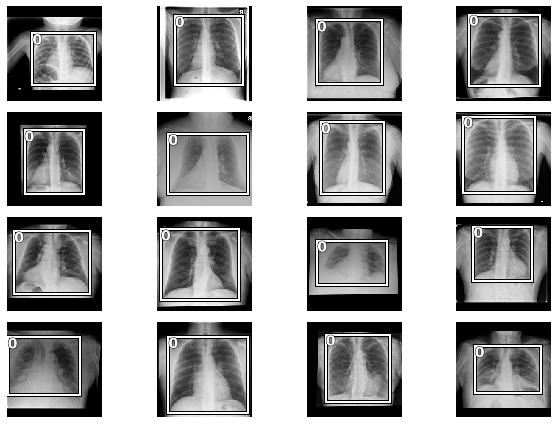

In [19]:
data.show_batch(10, figsize=(9,6))

In [20]:
data.valid_ds.items

array([PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/96895699535156938228135970872677525186_z25mmq.png'),
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/95707395722068271200818957258222229158_fqoqel.png'),
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/97600927297254707513662656394991173027_0k06p2.png'),
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/85622017620251286543763981488010444554_6gsfmu.png'),
       ...,
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/74815727493104157156940997460355763671_lgzagx.png'),
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/75627318848631590955141257004722136494_mrro2p.png'),
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/77914334473380412364913757909337796966_x0exbf.png'),
       PosixPath('/home/robert/data/covid/ROI_detection/roi_detection_subset/9

In [21]:
batch = next(iter(data.valid_dl))

In [22]:
batch[0][0][1]

tensor([[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        ...,
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
        [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
       device='cuda:0')

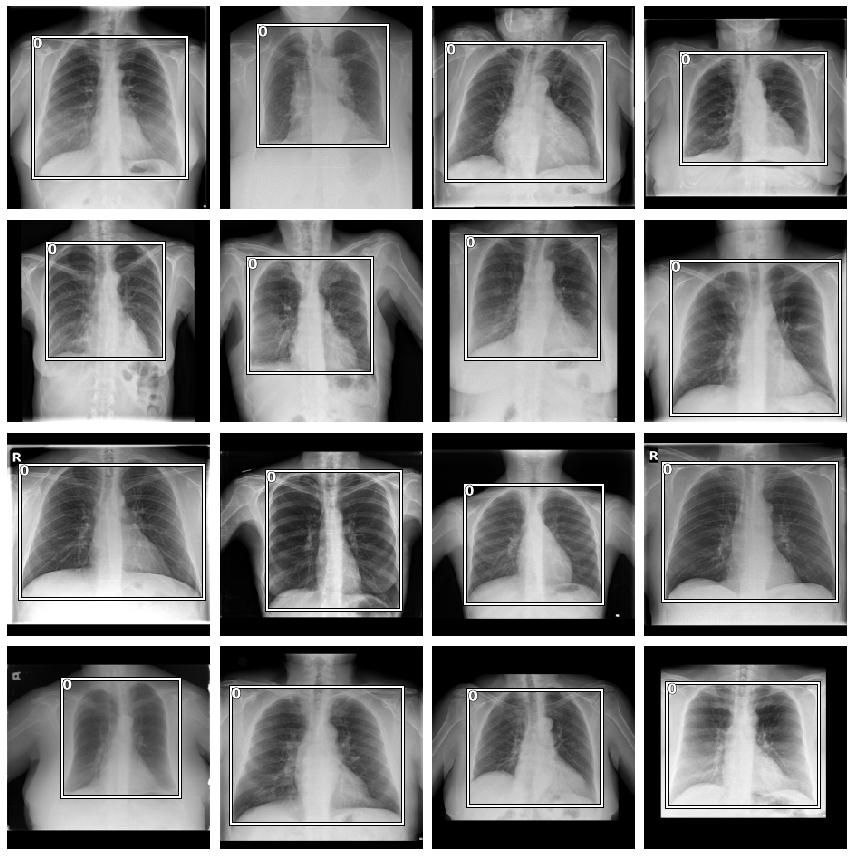

In [23]:
data.show_batch(rows=10, ds_type=DatasetType.Valid, figsize=(12,12))

## Train model
from https://github.com/radekosmulski/whale/blob/master/fluke_detection_redux.ipynb


In [24]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes):
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [25]:
SMOOTH = 1e-6

def iou_rm(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    # rm error not being byte 
    outputs = outputs > 0.5
    labels = labels.Byte()
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # Or thresholded.mean() if you are interested in average across the batch
    
    
# Numpy version
# Well, it's the same function, so I'm going to omit the comments

def iou_np(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded  # Or thresholded.mean()

In [26]:
class LungDetector(nn.Module):
    def __init__(self, arch=models.resnet18): # was 18
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = create_head(num_features_model(self.cnn) * 2, 4)
        
    def forward(self, im):
        x = self.cnn(im)
        x = self.head(x)
        return 2 * (x.sigmoid_() - 0.5)

In [27]:
def loss_fn(preds, targs, class_idxs):
    return L1Loss()(preds, targs.squeeze())

In [28]:
learn = Learner(data, LungDetector(arch=models.resnet50), loss_func=loss_fn)
learn.metrics = [lambda preds, targs, _: IoU(preds, targs.squeeze()).mean()]

In [29]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

Learner(data=ImageDataBunch;

Train: LabelList (755 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: StubbedObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/robert/data/covid/ROI_detection;

Valid: LabelList (83 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: StubbedObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/robert/data/covid/ROI_detection;

Test: None, model=LungDetector(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilati

In [30]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


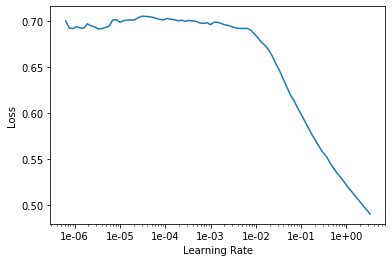

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr = 1e-1
%time learn.fit_one_cycle(100, 1e-2, div_factor=12, pct_start=0.2)

CPU times: user 5min 33s, sys: 3min 52s, total: 9min 26s
Wall time: 10min 56s


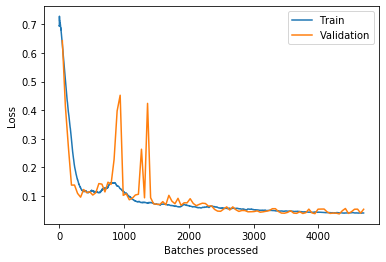

In [33]:
learn.recorder.plot_losses()

In [34]:
data.train_ds

LabelList (755 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: StubbedObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/robert/data/covid/ROI_detection

In [35]:
data.valid_ds

LabelList (83 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: StubbedObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /home/robert/data/covid/ROI_detection

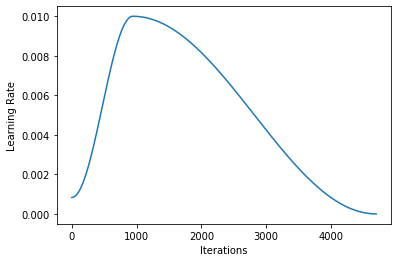

In [36]:
learn.recorder.plot_lr()

In [37]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


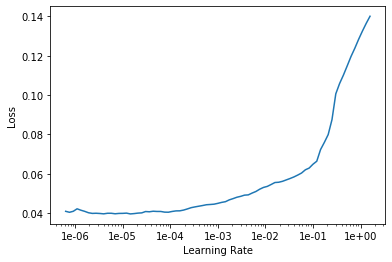

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
max_lr = 1e-2
lrs = np.array([max_lr/100, max_lr/10, max_lr])

In [40]:
%time learn.fit_one_cycle(200, max_lr) # was 120

CPU times: user 15min 28s, sys: 8min 3s, total: 23min 32s
Wall time: 26min 38s


In [45]:
learn.save('roi_detector_stage-1')


In [44]:
# doing this metrics [] because pickle in export does not accept lambda functions...
learn.metrics = []
learn.export('trained_roi_detetor_resnet_export.pkl')

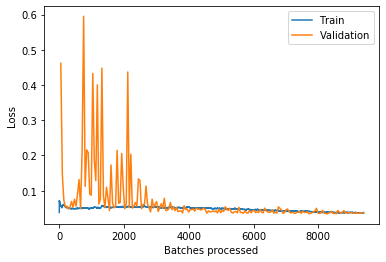

In [41]:
learn.recorder.plot_losses()


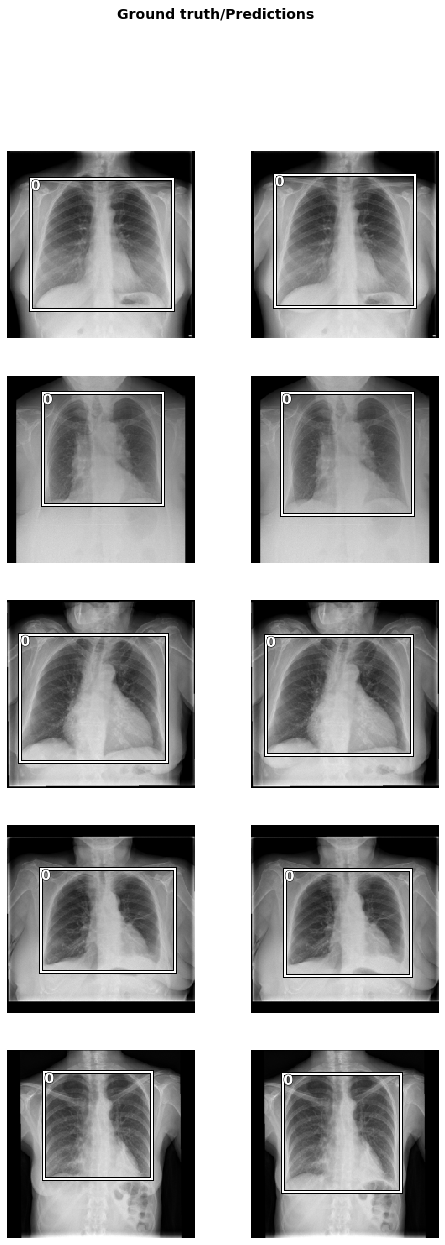

In [42]:
learn.show_results()

## Data augmentation

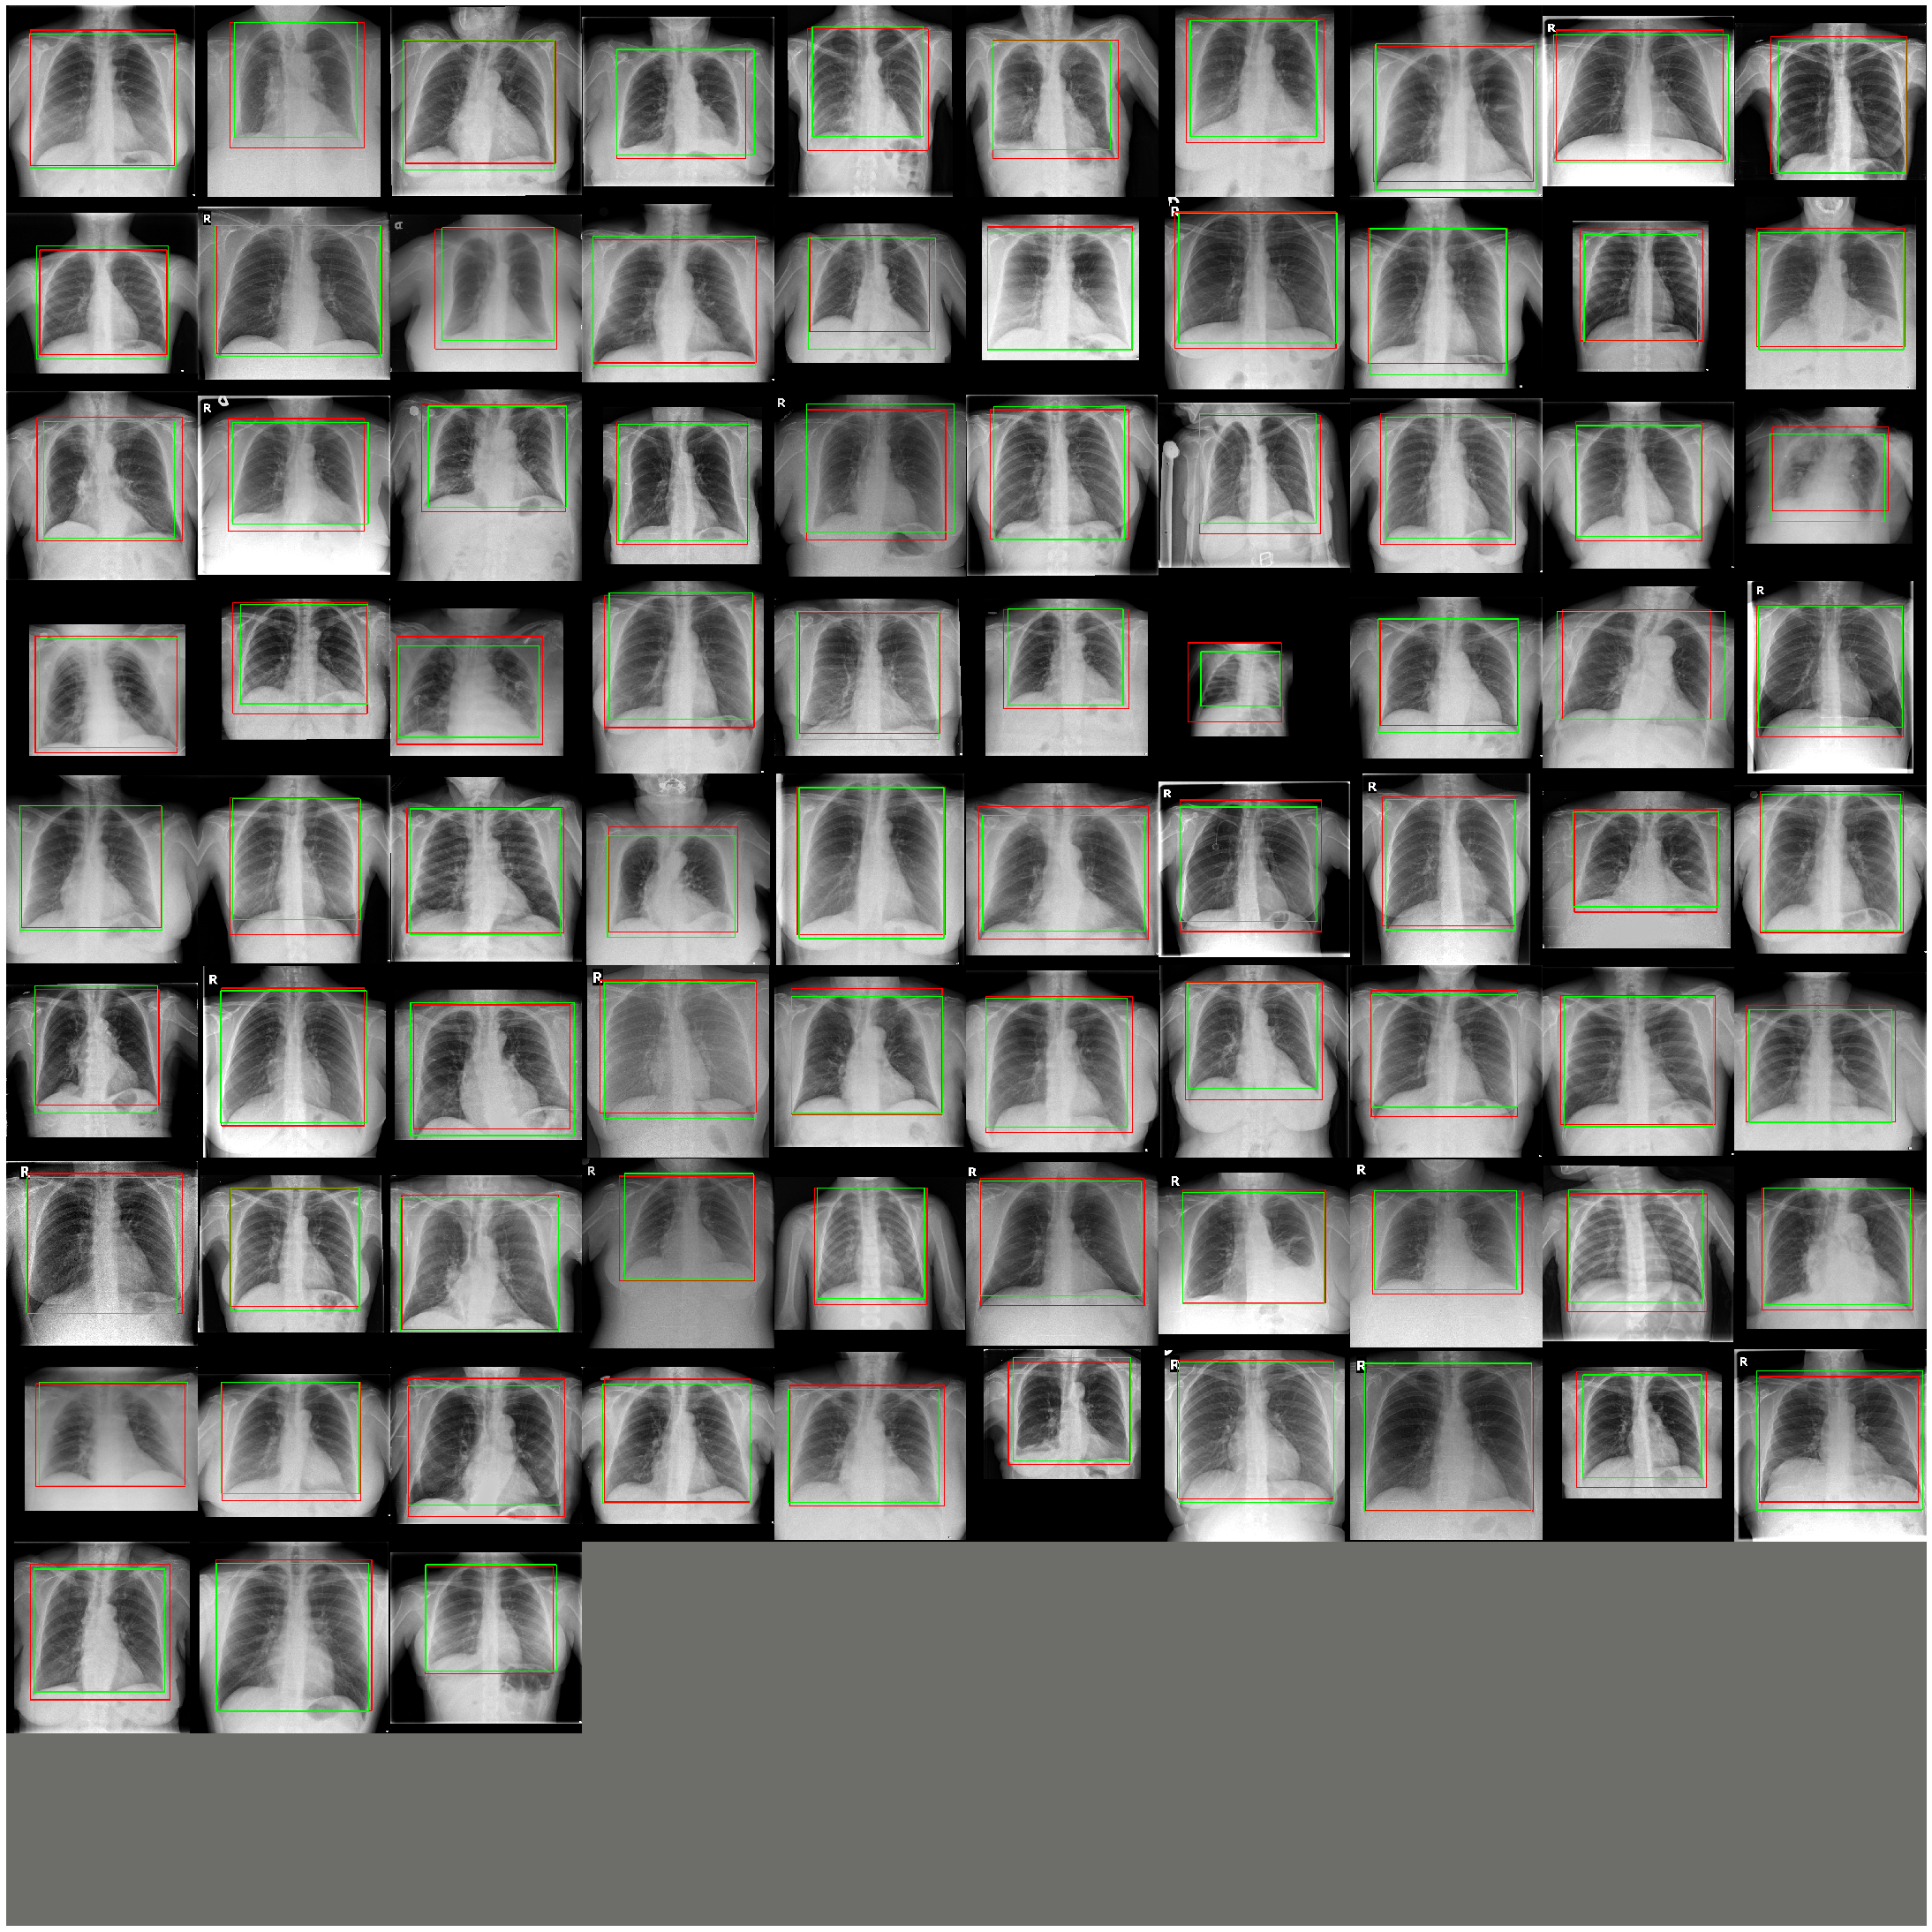

In [43]:
preds, targs = learn.get_preds()
#print(preds)
#print(targs)
 
#predicted_bboxes = ((preds + 1) / 2 * img_size).numpy()
#targets = ((targs + 1) / 2 *  img_size).numpy().squeeze()
predicted_bboxes = ((preds + 1) / 2).numpy()
targets = ((targs + 1) / 2).numpy().squeeze()

#print(predicted_bboxes)
#print(targets)

def draw_bbox(img, bbox, target=None, color=(255, 0, 0), thickness=2):
    sx,sy,ch = img.shape
#    print(sx,sy,ch)
    
    bbox[0] = bbox[0]*sy
    bbox[1] = bbox[1]*sx
    bbox[2] = bbox[2]*sy
    bbox[3] = bbox[3]*sx
    y_min, x_min, y_max, x_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    if target is not None:
        target[0] = target[0]*sy
        target[1] = target[1]*sx
        target[2] = target[2]*sy
        target[3] = target[3]*sx
        y_min, x_min, y_max, x_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=thickness)
    return img

def cv_read(path): 
    path = str(path)
#    print(path)
    im = cv2.imread(path, cv2.IMREAD_COLOR)
#    im = cv2.resize(im, (img_size,img_size))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Targets are in green, predictions in red.
ims = np.stack([draw_bbox(cv_read(data.valid_ds.items[i]), predicted_bboxes[i], targets[i]) for i in range(83)])
plt.figure(figsize=(40,40))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))